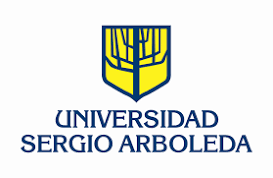

Udacity-cs344 HW4

Computación Paralela y distribuida

* Santiago Niño
* Esteban Rodriguez
* Daniel Velasquez

Abril 2023

In [ ]:
# Homework 4 for Udacity CS344 Course, Intro to Parallel Programming
# clone the code repo,
!git clone https://github.com/depctg/udacity-cs344-colab
!pip install git+https://github.com/depctg/nvcc4jupyter.git

# load cuda plugin
%config NVCCPluginV2.static_dir = True
%config NVCCPluginV2.relative_dir = "udacity-cs344-colab/src/HW4"
%load_ext nvcc_plugin

# change to work directory, generate makefiles
!mkdir udacity-cs344-colab/build
%cd udacity-cs344-colab/build
!cmake ../src

Cloning into 'udacity-cs344-colab'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 144 (delta 14), reused 12 (delta 12), pack-reused 120
Receiving objects: 100% (144/144), 3.93 MiB | 39.50 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/depctg/nvcc4jupyter.git to /tmp/pip-req-build-xxmxx_1k
  Running command git clone --filter=blob:none --quiet https://github.com/depctg/nvcc4jupyter.git /tmp/pip-req-build-xxmxx_1k
  Resolved https://github.com/depctg/nvcc4jupyter.git to commit 63b811d987446c2a3783845b7b85cda6e562b71a
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin
/content/udacity-cs344-colab/build/udacity-cs344-colab/build
CMake Deprecation Warning at CMakeLists.txt:8 (cma

In [ ]:
makefiletemp = open('../src/HW4/HW4.cu','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[5] = "#include <thrust/host_vector.h> \n"

makefiletemp = open('../src/HW4/HW4.cu','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
makefiletemp = open('../src/CMakeLists.txt','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[23] = "-Wno-deprecated-gpu-targets \n"

makefiletemp = open('../src/CMakeLists.txt','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
makefiletemp = open('../build/HW4/CMakeFiles/HW4.dir/HW4_generated_student_func.cu.o.cmake','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[75] = "-Wno-deprecated-gpu-targets \n"

makefiletemp = open('../build/HW4/CMakeFiles/HW4.dir/HW4_generated_student_func.cu.o.cmake','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
makefiletemp = open('../build/HW4/CMakeFiles/HW4.dir/HW4_generated_student_func.cu.o.cmake.pre-gen','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[75] = "-Wno-deprecated-gpu-targets \n"

makefiletemp = open('../build/HW4/CMakeFiles/HW4.dir/HW4_generated_student_func.cu.o.cmake.pre-gen','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
makefiletemp = open('../src/HW4/loadSaveImage.cpp','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[15] = "cv::Mat image = cv::imread(filename.c_str(), cv::IMREAD_COLOR | cv::IMREAD_ANYDEPTH); \n"
list_of_lines[45] = "cv::Mat image = cv::imread(filename.c_str(), cv::IMREAD_COLOR); \n"
list_of_lines[62] = "cv::cvtColor(image, imageRGBA, cv::COLOR_BGR2RGBA); \n"
list_of_lines[87] = "cv::cvtColor(imageRGBA, imageOutputBGR, cv::COLOR_RGBA2BGR); \n"
makefiletemp = open('../src/HW4/loadSaveImage.cpp','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
%%writefile ../src/HW4/student_func.cu

//Udacity HW 4
//Radix Sorting

#include "utils.h"
#include <thrust/host_vector.h>
#include <algorithm>
#include <cstring>

/* Red Eye Removal
   ===============

   For this assignment we are implementing red eye removal.  This is
   accomplished by first creating a score for every pixel that tells us how
   likely it is to be a red eye pixel.  We have already done this for you - you
   are receiving the scores and need to sort them in ascending order so that we
   know which pixels to alter to remove the red eye.
   Note: ascending order == smallest to largest
   Each score is associated with a position, when you sort the scores, you must
   also move the positions accordingly.
   Implementing Parallel Radix Sort with CUDA
   ==========================================
   The basic idea is to construct a histogram on each pass of how many of each
   "digit" there are.   Then we scan this histogram so that we know where to put
   the output of each digit.  For example, the first 1 must come after all the
   0s so we have to know how many 0s there are to be able to start moving 1s
   into the correct position.
   1) Histogram of the number of occurrences of each digit
   2) Exclusive Prefix Sum of Histogram
   3) Determine relative offset of each digit
        For example [0 0 1 1 0 0 1]
                ->  [0 1 0 1 2 3 2]
   4) Combine the results of steps 2 & 3 to determine the final
      output location for each element and move it there
   LSB Radix sort is an out-of-place sort and you will need to ping-pong values
   between the input and output buffers we have provided.  Make sure the final
   sorted results end up in the output buffer!  Hint: You may need to do a copy
   at the end.
 */



/// parallel histogram function on GPU
__global__ void hist_create(unsigned int* Hist,
			    unsigned int* const Vals,
			    unsigned int digit)
{
    int tid = threadIdx.x + blockIdx.x*blockDim.x;
    unsigned int mask = 1 << digit;
    unsigned int bin = (Vals[tid] & mask) >> digit;
    atomicAdd(&(Hist[bin]), 1);
}


/// parallel predicate on GPU
__global__ void predicate(unsigned int* const Vals,
			  unsigned int* Vals_saved0,
			  unsigned int* Vals_saved1,
			  unsigned int digit)
{

    int tid = threadIdx.x + blockIdx.x*blockDim.x;

    unsigned int mask = 1 << digit;
    unsigned int bin = (Vals[tid] & mask) >> digit;

    if (bin == 0) {
     Vals_saved0[tid] = 1;
     Vals_saved1[tid] = 0;
    }
  __syncthreads();

    if (bin == 1) {
     Vals_saved0[tid] = 0;
     Vals_saved1[tid] = 1;
    }

}

/// parallel exclusive sum on GPU
__global__ void exclus_sum(unsigned int*  Vals,
			   unsigned int* exc_sum,
			   int stepsize,
                           int whichblk  )
{

    int tid = threadIdx.x + blockIdx.x*blockDim.x + whichblk*520;
    unsigned int sum=0;

   exc_sum[tid] = Vals[tid];
   __syncthreads();

    if ( (tid-stepsize) >= 0 )  {
     sum  =  exc_sum[tid] + exc_sum[tid - stepsize];
    }
    else {
     sum = exc_sum[tid];
    }
    __syncthreads();
   exc_sum[tid] = sum;


}

/// parallel histogram function on GPU
__global__ void compact(unsigned int*  d_inputVals,
               		unsigned int*  d_inputPos,
               		unsigned int*  d_outputVals,
               		unsigned int*  d_outputPos,
               		unsigned int*  exc_sum0,
               		unsigned int*  exc_sum1,
               		unsigned int*  predicate0,
			unsigned int* Hist)
{
    int tid = threadIdx.x + blockIdx.x*blockDim.x;
    unsigned int digit = 1;
    if (digit == predicate0[tid] ) {
     unsigned int a = exc_sum0[tid];
     d_outputVals[a] = d_inputVals[tid];
     d_outputPos[a] = d_inputPos[tid];
    }
  __syncthreads();

    digit = 0;
    if ( digit == predicate0[tid] ) {
     unsigned int a = exc_sum1[tid] + Hist[0];
     d_outputVals[a] = d_inputVals[tid];
     d_outputPos[a] = d_inputPos[tid];
    }

}


/// parallel swap out to input on GPU
__global__ void swap_oi(unsigned int*  inputV,
			  unsigned int*  inputP,
			  unsigned int*  outputV,
			  unsigned int*  outputP)
{
    int myx = threadIdx.x + blockIdx.x*blockDim.x;
    int myy = threadIdx.y + blockIdx.y*blockDim.y;
    int myId = myx + myy*gridDim.x*blockDim.x;

     inputV[myId] = outputV[myId];
     inputP[myId] = outputP[myId];

}



void your_sort(unsigned int* const d_inputVals,
               unsigned int* const d_inputPos,
               unsigned int* const d_outputVals,
               unsigned int* const d_outputPos,
               const size_t numElems)
{
  unsigned int numBins = 2;
  unsigned int *d_binHistogram, *d_predicate0, *d_predicate1, *d_tempvals0, *d_tempvals1;
  unsigned int h_test[numElems];
  //unsigned int h_binHistogram[numBins],h_test[numElems],h_test2[numElems], h_inputVals[numElems],h_predicate0[numElems],h_predicate1[numElems];
  unsigned int n_dig=32;
  checkCudaErrors(cudaMalloc((void**) &d_binHistogram,  numBins*sizeof(unsigned int) ) );
  checkCudaErrors(cudaMalloc((void**) &d_predicate0, numElems*sizeof(unsigned int) ) );
  checkCudaErrors(cudaMalloc((void**) &d_predicate1, numElems*sizeof(unsigned int) ) );
  checkCudaErrors(cudaMalloc((void**) &d_tempvals0, numElems*sizeof(unsigned int) ) );
  checkCudaErrors(cudaMalloc((void**) &d_tempvals1, numElems*sizeof(unsigned int) ) );
  const dim3 blockSize(520 ,1, 1);
  const dim3 gridSize(1, 1, 1);

  printf("[");
  for (unsigned int digit = 0; digit < n_dig; ++digit) {
   checkCudaErrors(cudaMemset((void**) d_binHistogram, 0, numBins*sizeof(unsigned int) ) );
   checkCudaErrors(cudaMemset((void**) d_predicate0, 0, numElems*sizeof(unsigned int) ) );
   checkCudaErrors(cudaMemset((void**) d_tempvals0, 0, numElems*sizeof(unsigned int) ) );
   hist_create <<<gridSize, blockSize>>> (d_binHistogram, d_inputVals, digit);
    printf("i%d ", digit );
   predicate <<<gridSize, blockSize>>> ( d_inputVals,
			                 d_predicate0,
				         d_predicate1,
			                 digit);

    for(int s = 1; s <= int(numElems); s *= 2) {
     for (int j = 0; j < 424 ; j++) {
      exclus_sum <<<gridSize, blockSize>>> (d_predicate0, d_tempvals0, s, j);
      cudaDeviceSynchronize();
     }
    }

  checkCudaErrors(cudaMemcpy(h_test, d_tempvals0, numElems*sizeof(unsigned int), cudaMemcpyDeviceToHost));

 }
 printf("]\n");

 checkCudaErrors(cudaFree(d_binHistogram));
 checkCudaErrors(cudaFree(d_predicate0));
 checkCudaErrors(cudaFree(d_predicate1));
 checkCudaErrors(cudaFree(d_tempvals0));
 checkCudaErrors(cudaFree(d_tempvals1));

}

Overwriting ../src/HW4/student_func.cu


In [ ]:
# make the cuda project
!Wno-deprecated-gpu-targets
!make HW4
print("\n====== RESULT OF HW4 =======\n")
!bin/HW4 ../src/HW4/red_eye_effect.gold ../src/HW4/red_eye_effect_template_5.jpg

/bin/bash: Wno-deprecated-gpu-targets: command not found
CMake Deprecation Warning at CMakeLists.txt:8 (cmake_minimum_required):
  Compatibility with CMake < 2.8.12 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


CMake Deprecation Warning at HW3/CMakeLists.txt:8 (cmake_minimum_required):
  Compatibility with CMake < 2.8.12 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- Configuring done
-- Generating done
-- Build files have been written to: /content/udacity-cs344-colab/build/udacity-cs344-colab/build
[ 14%] Building NVCC (Device) object HW4/CMakeFiles/HW4.dir/HW4_generated_student_func.cu.o
[ 28%] Building NVCC (Device) object HW4/CMakeFiles/HW4.dir/HW4_generated_HW4.cu.o
[ 42%] 

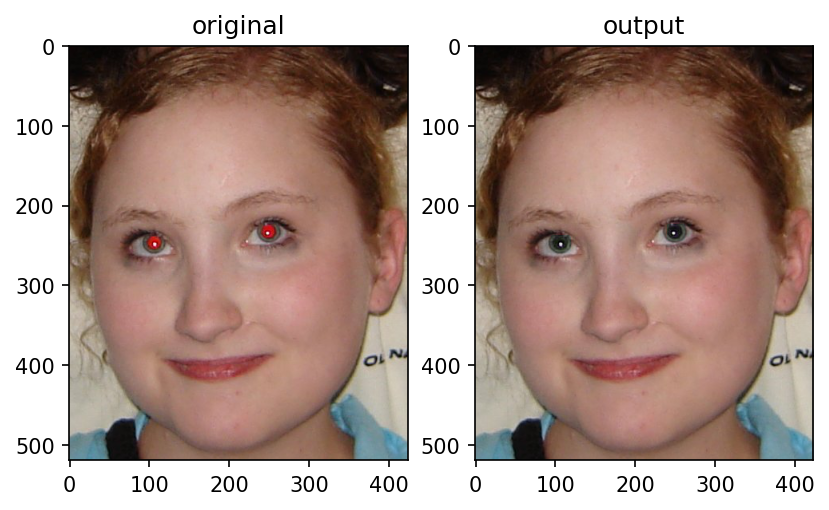

In [ ]:
# plot output images
import matplotlib.pyplot as plt
_,ax = plt.subplots(1,2, dpi=150)

ax[0].imshow(plt.imread("../src/HW4/red_eye_effect_5.jpg"))
ax[0].set_title("original")
ax[0].grid(False)

ax[1].imshow(plt.imread("HW4_output.png"))
ax[1].set_title("output")
ax[1].grid(False)

plt.show()

Notas:
* Del archivo /content/udacity-cs344-colab/src/HW4/HW4.cu, se añadió en la linea 6: #include <thrust/host_vector.h>
* Del archivo /content/udacity-cs344-colab/src/CMakeLists.txt, se cambió la linea 24 por: -Wno-deprecated-gpu-targets
* Del archivo /content/udacity-cs344-colab/build/HW4/CMakeFiles/HW4.dir/HW4_generated_student_func.cu.o.cmake, se cambió la linea 76 por: -Wno-deprecated-gpu-targets
* Del archivo /content/udacity-cs344-colab/build/HW4/CMakeFiles/HW4.dir/HW4_generated_student_func.cu.o.cmake.pre-gen, se cambió la linea 76 por: -Wno-deprecated-gpu-targets
* Del archivo /content/udacity-cs344-colab/src/HW4/loadSaveImage.cpp, se cambió de la linea 16 CV_LOAD_IMAGE_COLOR por cv::IMREAD_COLOR
* Del archivo /content/udacity-cs344-colab/src/HW4/loadSaveImage.cpp, se cambió de la linea 16 CV_LOAD_IMAGE_ANYDEPTH por cv::IMREAD_ANYDEPTH
* Del archivo /content/udacity-cs344-colab/src/HW4/loadSaveImage.cpp, se cambió de la linea 46 CV_LOAD_IMAGE_COLOR por cv::IMREAD_COLOR
* Del archivo /content/udacity-cs344-colab/src/HW4/loadSaveImage.cpp, se cambió de la linea 63 CV_BGR2RGBA por cv::COLOR_BGR2RGBA
* Del archivo /content/udacity-cs344-colab/src/HW4/loadSaveImage.cpp, se cambió de la linea 88 CV_RGBA2BGR por cv::COLOR_RGBA2BGR